# Measuring dependency relations' degree of functionality (1.2 updated)

It would be cool if we had a measurment for a relation's degree of functionality, that is, whether it mainly takes functional dependents or content dependents. Here's my suggestion.

My suggestion relies on three assumptions:

- A functional deprel is present in as many languages as possible. This can be measured with the mean probability of a deprel over all languages.
- A functional deprel is also a closed class, meaning the amount of word dependents should be relatively small. This can be measured by the conditional entropy of the probability distribution of all word dependents given the deprel. This is then averaged across all languages.
- A functional deprel has an equal distribution in all languages. This can be measured by the conditional entropy of a deprel given its cross-lingual probability distribution. I'm not sure about this one.

More concisely, this tells us:

### Crosslingual deprel entropy

"It should be equally common in all languages"

### Crosslingual deprel probability

"It should be a common relation in all languages"

### Inverse word entropy

"It should have a small number of word dependents"


## Summary

Inverse word entropy works best alone, while crosslingual deprel entropy and crosslingual deprel probability both have their weaknesses.

In [42]:
# Matplotlib
%matplotlib inline
import matplotlib as mpl
from matplotlib import pylab
import matplotlib.pyplot as plt
pylab.rcParams['figure.figsize'] = (10.0, 7.0)
mpl.style.use('ggplot')
from matplotlib.backends.backend_pgf import FigureCanvasPgf
mpl.backend_bases.register_backend('pgf', FigureCanvasPgf)

# Remove warnings
import warnings
#warnings.filterwarnings('ignore')

import sys, os
from os.path import join
sys.path.append("../tools/")
from collections import defaultdict

# Data management libraries
import pandas as pd
#import seaborn as sns
import scipy as sp
import scipy.stats

# Treebank utils, found in "../tools"
import udeval, udtree, lang_utils, dependency_classes

file_format = "conllu"
train_type = "train"
fine_grained_deprels = False
gold_output_base = "/Users/jimmy/dev/edu/nlp-rod/udeval/resources/universaldependencies1-2/universal-dependencies-1.2/"
file_prefix = "degree_of_functionality"

gold_files = lang_utils.get_ud_paths(gold_output_base, type_=train_type, format_=file_format, coarse=False)

def word_dependent_entropy(trees):
    # dep_word_freqs[deprel][word] = freq
    dep_word_freqs = defaultdict(lambda : defaultdict(int))
    total = 0
    for tree in trees:
        for word, deprel in zip(tree.words, tree.deprels):
            if not fine_grained_deprels:
                deprel = deprel.split(":")[0]
            dep_word_freqs[deprel][word] += 1
    df = pd.DataFrame(dep_word_freqs).fillna(0)  # frequencies
    df = df.divide(df.sum(axis=0), axis=1)       # word probability conditioned on deprel
    entropy_upper_bound = np.log(len(df.index))
    df = pd.Series(sp.stats.entropy(df), index=df.columns).sort_values()
    return df / entropy_upper_bound  # normalize

def inverse_word_entropy(treebanks):
    lang_entropies = {}
    for lang, treebank in treebanks.items():
        lang_entropies[lang] = word_dependent_entropy(udtree.from_files(treebank))
    return pd.DataFrame(lang_entropies).fillna(0.5).mean(axis=1).sort_values()

def crosslingual_deprel_entropy(treebanks):
    # dep_word_freqs[lang][deprel] = freq
    dep_freqs = defaultdict(lambda : defaultdict(int))
    total = 0
    for lang, treebank in treebanks.items():
        for tree in udtree.from_files(treebank):
            for deprel in tree.deprels:
                if not fine_grained_deprels:
                    deprel = deprel.split(":")[0]
                dep_freqs[lang][deprel] += 1
    df = pd.DataFrame(dep_freqs).fillna(0)  # frequencies
    df = df.divide(df.sum(axis=1), axis=0).transpose()
    entropy_upper_bound = np.log(len(df.index))  # ln num_deprels
    df = pd.Series(sp.stats.entropy(df), index=df.columns) / entropy_upper_bound
    return df.sort_values()

def crosslingual_deprel_probability(treebanks):
    # dep_word_freqs[lang][deprel] = freq
    dep_freqs = defaultdict(lambda : defaultdict(int))
    total = 0
    for lang, treebank in treebanks.items():
        for tree in udtree.from_files(treebank):
            for deprel in tree.deprels:
                if not fine_grained_deprels:
                    deprel = deprel.split(":")[0]
                dep_freqs[lang][deprel] += 1
    df = pd.DataFrame(dep_freqs).fillna(0)  # frequencies
    df = df.divide(df.sum(axis=0), axis=1).mean(axis=1).sort_values()
    return df

In [44]:
#crosslingual_probabilities = crosslingual_deprel_probability(gold_files)
#crosslingual_entropies = crosslingual_deprel_entropy(gold_files)
inverse_word_entropies = inverse_word_entropy(gold_files)

## Inverse word entropy

In [45]:
inverse_word_entropies.sort_values(ascending=False).to_csv('../data/' + file_prefix + '.inverse_word_entropy.csv')
inverse_word_entropies.sort_values(ascending=False)

conj          0.787191
nmod          0.784227
amod          0.712432
dobj          0.711663
root          0.701767
nsubj         0.681228
acl           0.672400
advcl         0.649315
ccomp         0.613860
appos         0.599161
xcomp         0.592473
name          0.565665
advmod        0.538054
nsubjpass     0.526781
csubj         0.507759
remnant       0.502777
list          0.479554
compound      0.477336
parataxis     0.476370
iobj          0.474883
reparandum    0.471234
nummod        0.469234
dislocated    0.437807
goeswith      0.423262
foreign       0.420653
dep           0.379487
vocative      0.376562
discourse     0.346308
csubjpass     0.341963
det           0.308794
expl          0.283816
case          0.283542
aux           0.276254
cop           0.274486
auxpass       0.264134
mwe           0.250968
mark          0.222706
punct         0.183170
cc            0.132400
neg           0.056917
dtype: float64

__We don't like that expl is so far down__

This is due to expl not being used in all languages (see appendix at bottom). The other parts are quite good, though.

## Inverse word entropy * crosslingual entropy

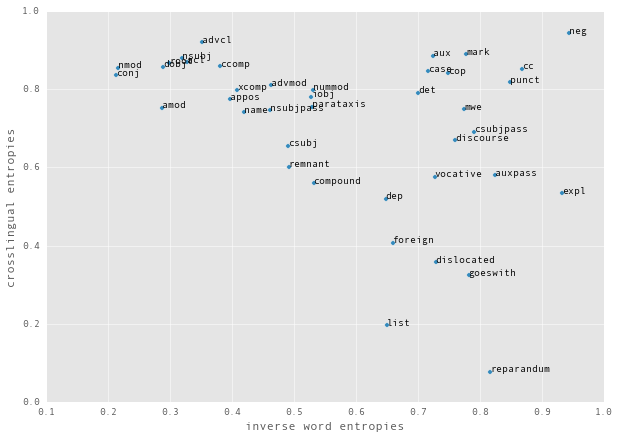

In [25]:
entropies = pd.concat([inverse_word_entropies, crosslingual_entropies], axis=1).rename(columns={0: "inverse word entropies", 1: "crosslingual entropies"})
ax = entropies.plot(kind='scatter', x="inverse word entropies", y="crosslingual entropies")
for label, x, y in entropies.itertuples():
    ax.annotate(label, (x, y))
    
invcross = (entropies["inverse word entropies"] * entropies["crosslingual entropies"]).sort_values(ascending=False)

__We don't like that advmod, vocative, and compound are so far up__

This is due to classes being _equally unprobable_ in all languages.

## Inverse word entropy * crosslingual probability

punct         0.093563
case          0.077783
det           0.041003
cc            0.033624
nmod          0.032862
mark          0.021862
nsubj         0.021260
advmod        0.020210
aux           0.018021
root          0.017923
amod          0.016178
dobj          0.014611
cop           0.010565
conj          0.008447
neg           0.007677
compound      0.006833
nummod        0.006727
iobj          0.006402
acl           0.005936
advcl         0.005696
xcomp         0.004707
expl          0.004485
ccomp         0.003856
name          0.003510
auxpass       0.003253
discourse     0.002675
appos         0.002650
mwe           0.002520
parataxis     0.002081
dep           0.001913
nsubjpass     0.001435
csubj         0.000924
vocative      0.000705
remnant       0.000463
foreign       0.000287
dislocated    0.000131
list          0.000128
goeswith      0.000089
csubjpass     0.000062
reparandum    0.000006
dtype: float64

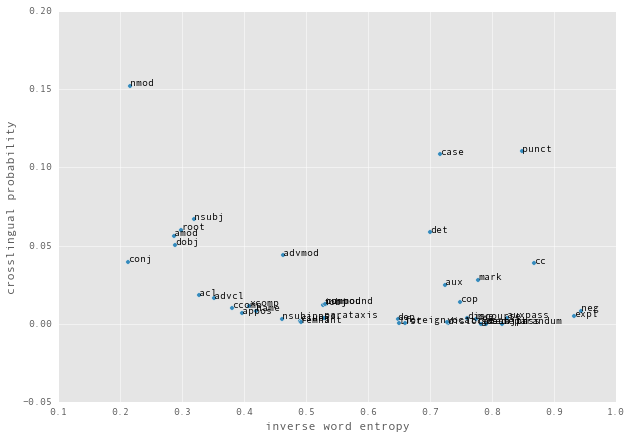

In [24]:
entropies = pd.concat([inverse_word_entropies, crosslingual_probabilities], axis=1).rename(columns={0: "inverse word entropy", 1: "crosslingual probability"})
ax = entropies.plot(kind='scatter', x="inverse word entropy", y="crosslingual probability")
for label, x, y in entropies.itertuples():
    ax.annotate(label, (x, y))
    
(entropies["inverse word entropy"] * entropies["crosslingual probability"]).sort_values(ascending=False)

### We don't like that nmod is so far up

This is due to it being a quite common content class.

# Conclusion

Using inverse word entropy seems to be the best measurment so far.


## Appendix: Heatmap of inverse word entropy

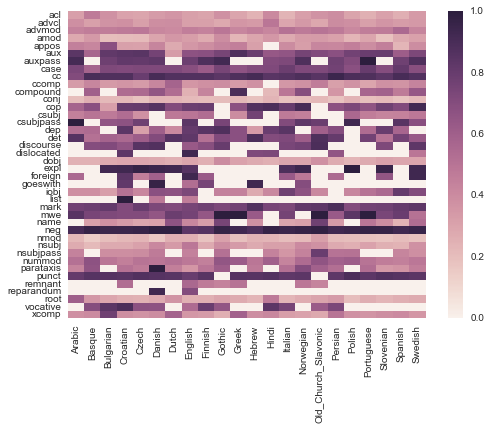

In [6]:
def lang_iwe(treebanks):
    lang_entropies = {}
    for lang, treebank in treebanks.items():
        lang_entropies[lang] = word_dependent_entropy(udtree.from_files(treebank))
    return 1 - (pd.DataFrame(lang_entropies).fillna(1))

sns.heatmap(lang_iwe(gold_files))

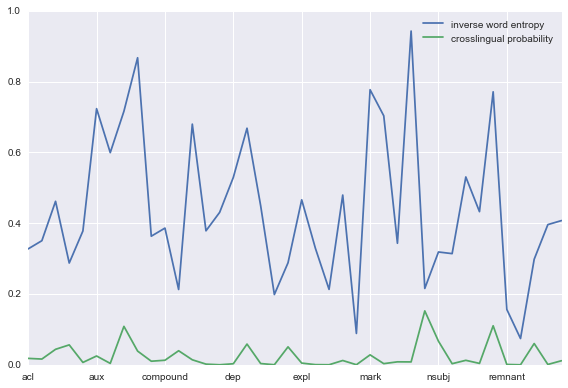

In [7]:
ax = entropies.plot()
plt.tight_layout()
#plt.savefig('hej.pgf')

# Paper figures

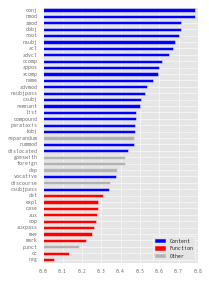

In [47]:
from matplotlib.patches import Patch
colmap = {deprel: 'red' for deprel in dependency_classes.function_dependents}
colmap.update({deprel: 'blue' for deprel in dependency_classes.content_dependents})
colmap.update({deprel: (0.7, 0.7, 0.7) for deprel in dependency_classes.nonsemantic_dependents})
colors = list(map(lambda deprel: colmap[deprel], inverse_word_entropies.sort_values(ascending=True).index))
fhandle = Patch(color='red', label='Function')
chandle = Patch(color='blue', label='Content')
ohandle = Patch(color=(0.7, 0.7, 0.7), label='Other')
ax = inverse_word_entropies.sort_values(ascending=True).plot(kind='barh', fontsize=5, figsize=(3, 4), color=colors)
plt.legend(handles=[chandle, fhandle, ohandle], loc=4, fontsize=5)
plt.tight_layout()
plt.savefig('../paper/figures/inverse_word_entropy.pgf')